## Anchor Analysis Figures

TDP-43 C/N and STMN2 quantification and statistics.

This uses the pvalues calculated in anchor_phenotype_stats.py and performs FDR correction before assessing significance for each set of analyses.

In [1]:
import os
import warnings

import duckdb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

from fals.config import ROOT_DATA_PATH

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# load in data from s3
# generated by anchor_phenotype_stats.py
s3_root = os.path.join(ROOT_DATA_PATH, "anchor", "stats")
donor_stats = pd.read_csv(os.path.join(s3_root, "donor_level_model_stats.csv"))
mut_stats = pd.read_csv(os.path.join(s3_root, "mutant_level_model_stats.csv"))
density_pair_ttests = pd.read_csv(os.path.join(s3_root, "paired_density_ttests.csv"))

all_wells = pd.read_csv(os.path.join(s3_root, "all_wells.csv"))
passing_wells = pd.read_csv(os.path.join(s3_root, "passing_wells.csv"))

In [4]:
# Aliases
tdp43_ratio = "median_cyto_nucleus_mask_ratio_TDP43_pixel_intensity"
well_tdp43_ratio = "well_TDP43_ratio"
stmn2 = "median_cell_mask_STMN2_pixel_intensity"
well_stmn2 = "well_STMN2_cell_intensity"

# normalized well level stats
norm_tdp43_ratio = "well_TDP43_ratio_norm"
norm_stmn2 = "well_STMN2_cell_intensity_norm"
norm_stmn2_neurite = "well_STMN2_neurite_intensity_norm"

dmso = "Dimethyl sulfoxide [MilliporeSigma]"
bortezomib = "Bortezomib [Tocris]"
puromycin = "Puromycin dihydrochloride [MilliporeSigma]"
thapsigargin = "Thapsigargin [SelleckChem]"
tunicamycin = "Tunicamycin [MilliporeSigma]"

drug_compounds = [bortezomib, puromycin, thapsigargin, tunicamycin]
all_compound = [dmso] + drug_compounds
dose_pairs = [(dmso, 0), (bortezomib, 0.0078), (puromycin, 3.4965), (thapsigargin, 0.0137), (tunicamycin, 0.4996)]

wt_categories = ["Wild-Type", "Engineered Familial Control", "Corrected Familial Mutation"]
wt_filter = ",".join(f"'{c}'" for c in wt_categories)
disease_categories = ["Familial Patient", "Engineered Familial", "Over-Expression Familial"]
disease_filter = ",".join(f"'{c}'" for c in disease_categories)

## Figure 2E and Supplemental 2E, F
* Plot the dosage curves for TDP-43, STMN2 and STMN2 in neurites.
* Highlight dosage used.
* Show seeding density.
* Use only WT lines (BTC and other non-disease lines)
* Use only group1-4

In [5]:
passing_rel = duckdb.from_df(passing_wells)
fig2_rel = passing_rel.filter(f"disease_category in ({wt_filter})").filter("group_id in (1, 2, 3, 4)")

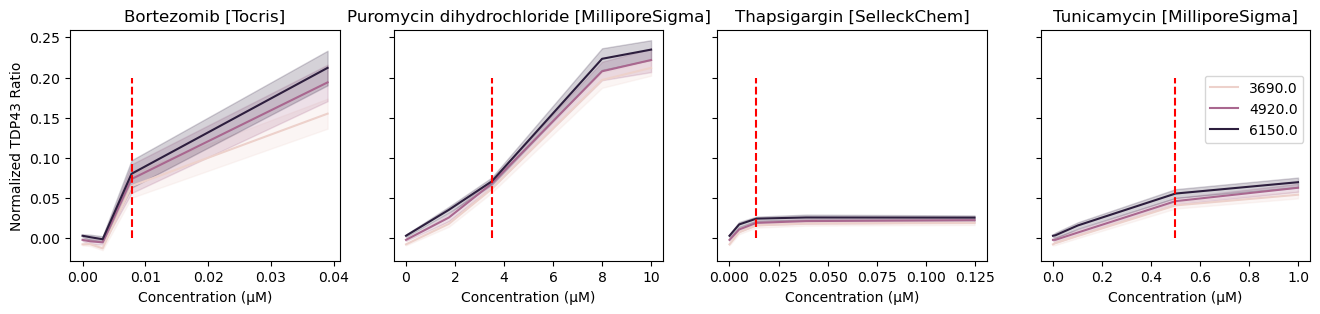

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharey=True)
for i, drug in enumerate(drug_compounds):
    graph = sns.lineplot(
        data=fig2_rel.filter(f"compound_name in ('{dmso}', '{drug}')").project(
            f"concentration_uM, {norm_tdp43_ratio}, total_cells_well"
        ).df(),
        y=norm_tdp43_ratio,
        x="concentration_uM",
        hue="total_cells_well",
        ax=ax[i]
    )
    graph.set(xlabel="Concentration (µM)")
    graph.set(ylabel="Normalized TDP43 Ratio")
    graph.title.set_text(drug)
    target_dose = dose_pairs[i+1][1]
    ax[i].plot([target_dose, target_dose], [0, 0.2], 'r--')
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].get_legend().remove()
fig.legend(handles, labels, bbox_to_anchor=(0.9,0.75))

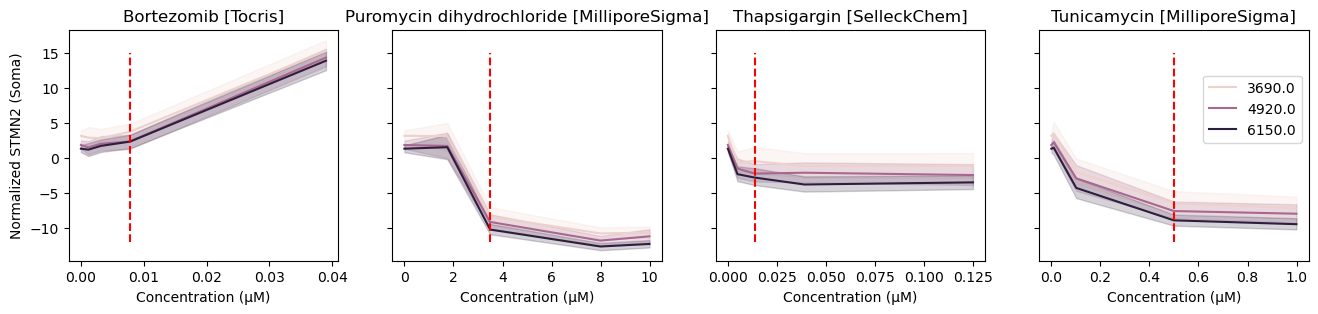

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharey=True)
for i, drug in enumerate(drug_compounds):
    graph = sns.lineplot(
        data=fig2_rel.filter(f"compound_name in ('{dmso}', '{drug}')").project(
            f"concentration_uM, {norm_stmn2}, total_cells_well"
        ).df(),
        y=norm_stmn2,
        x="concentration_uM",
        hue="total_cells_well",
        ax=ax[i]
    )
    graph.set(xlabel="Concentration (µM)")
    graph.set(ylabel="Normalized STMN2 (Soma)")
    graph.title.set_text(drug)
    target_dose = dose_pairs[i+1][1]
    ax[i].plot([target_dose, target_dose], [-12, 15], 'r--')
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].get_legend().remove()
fig.legend(handles, labels, bbox_to_anchor=(0.9,0.75))

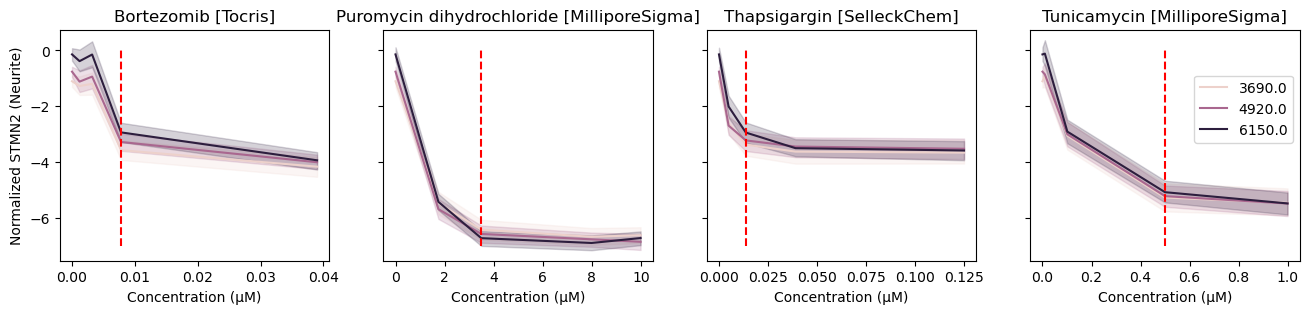

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharey=True)
for i, drug in enumerate(drug_compounds):
    graph = sns.lineplot(
        data=fig2_rel.filter(f"compound_name in ('{dmso}', '{drug}')").project(
            f"concentration_uM, {norm_stmn2_neurite}, total_cells_well"
        ).df(),
        y=norm_stmn2_neurite,
        x="concentration_uM",
        hue="total_cells_well",
        ax=ax[i]
    )
    graph.set(xlabel="Concentration (µM)")
    graph.set(ylabel="Normalized STMN2 (Neurite)")
    graph.title.set_text(drug)
    target_dose = dose_pairs[i+1][1]
    ax[i].plot([target_dose, target_dose], [-7, 0], 'r--')
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].get_legend().remove()
fig.legend(handles, labels, bbox_to_anchor=(0.9,0.75))

## Figure 3 and Supp Fig 3

### Heatmap of primary experiment data using fixed effects model for tdp43 ratio
* Group 1-4
* Model is feature ~ C(mut/wt) + C(donor) + C(density) + C(group)
* Post-hoc ttest of mut vs wt and show value of coefficient only if p<0.05
* Remove HOM mutants, which are not included in the text summary
* Correct for FDR when determining significance for heatmaps and text summary

Also included are summary statistics in the text for the total number of tested conditions and significant differences.

Text(0.5, 1.0, 'TDP43 Mislocalization: Coefficient')

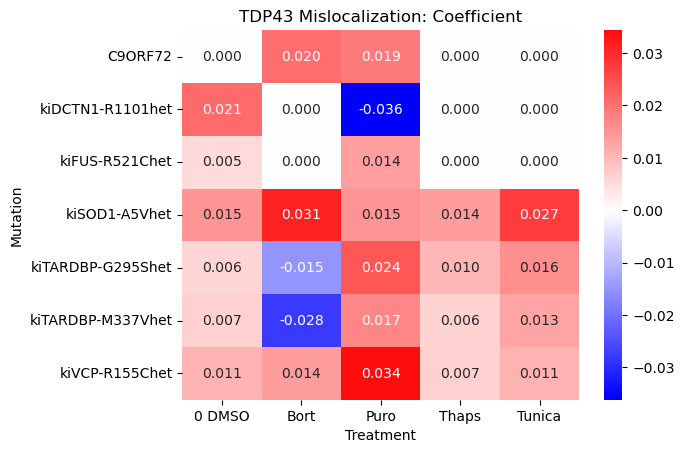

In [9]:
mut_stats_rel = duckdb.from_df(mut_stats)
tdp_df = (
    mut_stats_rel
    .filter("experiment = 'Exp1'")
    .filter("model = 'linear-fixed-well_TDP43_ratio_norm'")
    .filter("mutation not ilike '%hom%'")
    .project("mutation as Mutation, compound as Treatment, donor_interact_pval, donor_interact_coeff as Coeff")
).df()
is_sig, fdr_pval = fdrcorrection(tdp_df["donor_interact_pval"], alpha=0.05)
tdp_df.loc[~is_sig, "Coeff"] = 0.0
tdp_hm = tdp_df.pivot(index="Mutation", columns="Treatment", values="Coeff")
sns.heatmap(tdp_hm, annot=True, fmt=".3f", cmap='bwr', center=0)
plt.title("TDP43 Mislocalization: Coefficient")

Text(0.5, 1.0, 'TDP43 Mislocalization: Paired Density')

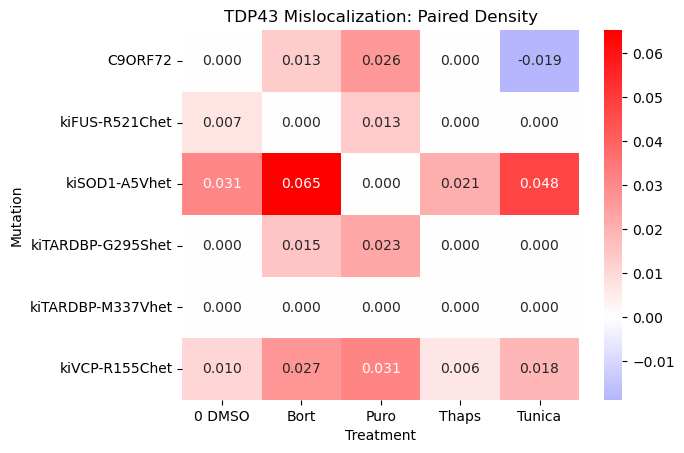

In [10]:
tdp_df_tt = (
    mut_stats_rel
    .filter("experiment = 'Exp1'")
    .filter("model = 'paired-fixed-well_TDP43_ratio_norm'")
    .filter("mutation not ilike '%hom%'")
    .project("mutation as Mutation, compound as Treatment, donor_interact_pval, donor_interact_coeff as Coeff")
).df()
is_sig_tt, fdr_pval_tt = fdrcorrection(tdp_df_tt["donor_interact_pval"], alpha=0.05)
tdp_df_tt.loc[~is_sig_tt, "Coeff"] = 0.0
tdp_hm_tt = tdp_df_tt.pivot(index="Mutation", columns="Treatment", values="Coeff").fillna(0.0)
sns.heatmap(tdp_hm_tt, annot=True, fmt=".3f", cmap='bwr', center=0)
plt.title("TDP43 Mislocalization: Paired Density")

Get the overlap between the 2 analysis methods

In [11]:
joined = pd.merge(tdp_df, tdp_df_tt, how="outer", on=["Mutation", "Treatment"], suffixes=["_model", "_tt"])
both_significant = joined[(joined["Coeff_model"] > 0) & (joined["Coeff_tt"] > 0)]
print(f"{len(both_significant)} out of {len(joined)}")

14 out of 35


Get the total number of FDR corrected changes in TDP43 across donor comparisons.

In [12]:
donor_rel = duckdb.from_df(donor_stats)
all_exp = (donor_rel
    .filter("model = 'linear-well_TDP43_ratio_norm'")
    .filter("mutation not ilike '%hom%'")
    .project("mutation as Mutation, compound as Treatment, donor_interact as Donor, donor_interact_pval, donor_interact_coeff as Coeff")
).df()
is_sig_all, fdr_pval_all = fdrcorrection(all_exp["donor_interact_pval"], alpha=0.05)
all_exp.loc[:, "FDR_pval"] = fdr_pval_all
all_exp.loc[:, "FDR_sig"] = is_sig_all
all_exp.loc[:, "FDR_sig_positive"] = is_sig_all * (all_exp["Coeff"] > 0.)

print(f"{sum(is_sig_all)} out of {len(all_exp)} have significant changes in TDP-43 C/N")

143 out of 253 have significant changes in TDP-43 C/N


In [13]:
all_exp.groupby(["Mutation", "Treatment"])["FDR_sig_positive"].aggregate(["sum", "mean", "count"])

sum      mean  count
Mutation          Treatment                      
C9ORF72           0 DMSO       6  0.400000     15
                  Bort         5  0.555556      9
                  Puro         4  0.444444      9
                  Thaps        3  0.333333      9
                  Tunica       3  0.333333      9
kiDCTN1-R1101het  0 DMSO       1  1.000000      1
                  Bort         0  0.000000      1
                  Puro         0  0.000000      1
                  Thaps        0  0.000000      1
                  Tunica       0  0.000000      1
kiFUS-R521Chet    0 DMSO       5  0.555556      9
                  Bort         2  0.222222      9
                  Puro         5  0.555556      9
                  Thaps        3  0.333333      9
                  Tunica       5  0.555556      9
kiSOD1-A5Vhet     0 DMSO       6  0.461538     13
                  Bort         2  0.285714      7
                  Puro         3  0.428571      7
                  Thaps        3  0.428571      7
                  Tunica       3  0.428571      7
kiTARDBP-G295Shet 0 DMSO       3  0.250000     12
                  Bort         2  0.333333      6
                  Puro         2  0.333333      6
                  Thaps        2  0.333333      6
                  Tunica       4  0.666667      6
kiTARDBP-M337Vhet 0 DMSO       5  0.357143     14
                  Bort         1  0.166667      6
                  Puro         2  0.333333      6
                  Thaps        1  0.166667      6
                  Tunica       2  0.333333      6
kiVCP-R155Chet    0 DMSO      10  0.769231     13
                  Bort         1  0.166667      6
                  Puro         5  0.833333      6
                  Thaps        5  0.833333      6
                  Tunica       6  1.000000      6

Above is a count of donor+experiment runs in each condition where there was a significant positive increase in TDP-43 C/N.  VCP still looks nice.  C9 doesn't hold as well in Bort.

## Heatmap figure for STMN2 from the supplemental

Text(0.5, 1.0, 'STMN2 Intensity (Soma): Coefficient')

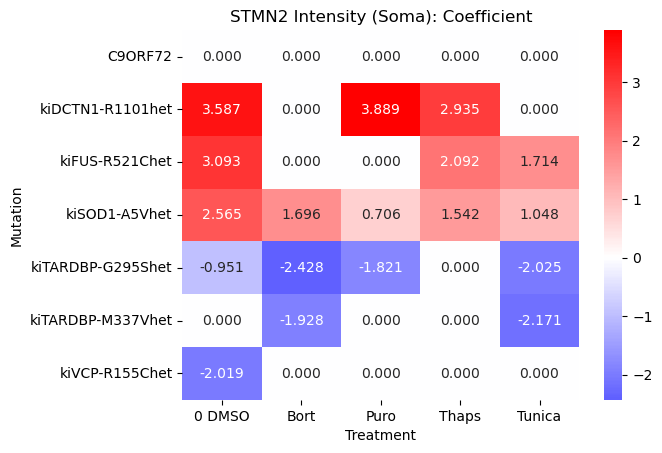

In [14]:
stmn_df = (
    mut_stats_rel
    .filter("experiment = 'Exp1'")
    .filter("model = 'linear-fixed-well_STMN2_cell_intensity_norm'")
    .filter("mutation not ilike '%hom%'")
    .project("mutation as Mutation, compound as Treatment, donor_interact_pval, donor_interact_coeff as Coeff")
).df()
is_sig_stmn, fdr_pval_stmn = fdrcorrection(stmn_df["donor_interact_pval"], alpha=0.05)
stmn_df.loc[~is_sig_stmn, "Coeff"] = 0.0
stmn_hm = stmn_df.pivot(index="Mutation", columns="Treatment", values="Coeff")
sns.heatmap(stmn_hm, annot=True, fmt=".3f", cmap='bwr', center=0)
plt.title("STMN2 Intensity (Soma): Coefficient")

## Bar plots

In [15]:
insitro_colors_wt = [
    "#2e898dff",
    "#136e72ff",
    "#81c4c7ff",
    "#abebeeff",
    "#bdd0d1ff",
    "#ff80ff",
]
insitro_colors_disease = [
    "#ffd447",
    "#e6acc9",
    "#f9bf3aff",
    "#f8d177ff",
    "#fce5b0ff",
    "#fab20cff",
    "#f5d58bff",
]
alternating = [val for pair in zip(insitro_colors_wt, insitro_colors_disease) for val in pair]

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

def plot_coeff(statsdf: pd.DataFrame, model: str, compound: str):
    df = statsdf[(statsdf.model == model) & (statsdf.compound == compound)]
    mutations = df['mutation'].unique()
    experiments = ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5"]
    donors = df['donor_interact'].unique()
    num_mutations = len(mutations)
    fig, axes = plt.subplots(1, num_mutations, figsize=(20, 4), sharey=True)
    for i, mutation in enumerate(mutations):
        data = df.loc[df['mutation'] == mutation]
        ax = axes[i]
        data_pv = data.pivot(index="donor_interact", columns="experiment", values="donor_interact_coeff")
        yerr = data.pivot(index="donor_interact", columns="experiment", values="ci")
        data_pv.plot(kind="bar", yerr=yerr, rot=0, ax=ax, color=alternating)
        ax.set_title(mutation)
        ax.set_xlabel("Donor")
        ax.tick_params("x", labelrotation=45)
        if i != 0:
            ax.set_ylabel("")
            ax.get_legend().remove()
        else:
            ax.get_legend().set_ncols(2)
            ax.set_ylabel("Model Coefficient")

In [16]:
donor_stats.loc[:, "ci"] = donor_stats.upper_ci - donor_stats.donor_interact_coeff # upper/lower are symmetric
donor_stats.head()

,Unnamed: 0,experiment,compound,model,mutation,donor_interact,donor_interact_pval,donor_interact_coeff,significant,lower_ci,upper_ci,ci
0,0,Exp1,0 DMSO,linear-well_TDP43_ratio_norm,C9ORF72,Dins605,8.186905e-01,0.000382,True,-0.002899,0.003663,0.003281
1,1,Exp1,0 DMSO,linear-well_TDP43_ratio_norm,C9ORF72,Dins604,1.762543e-09,-0.010561,True,-0.013867,-0.007255,0.003306
2,2,Exp1,0 DMSO,linear-well_TDP43_ratio_norm,C9ORF72,Dins390,3.545848e-34,0.033389,True,0.028926,0.037851,0.004462
3,3,Exp1,0 DMSO,linear-well_STMN2_cell_intensity_norm,C9ORF72,Dins605,7.609970e-01,0.267190,False,-1.462279,1.996659,1.729469
4,4,Exp1,0 DMSO,linear-well_STMN2_cell_intensity_norm,C9ORF72,Dins604,2.888975e-08,-5.097786,True,-6.840414,-3.355157,1.742629


Text(0.5, 1.05, 'TDP43 C/N Ratio Linear Model (DMSO)')

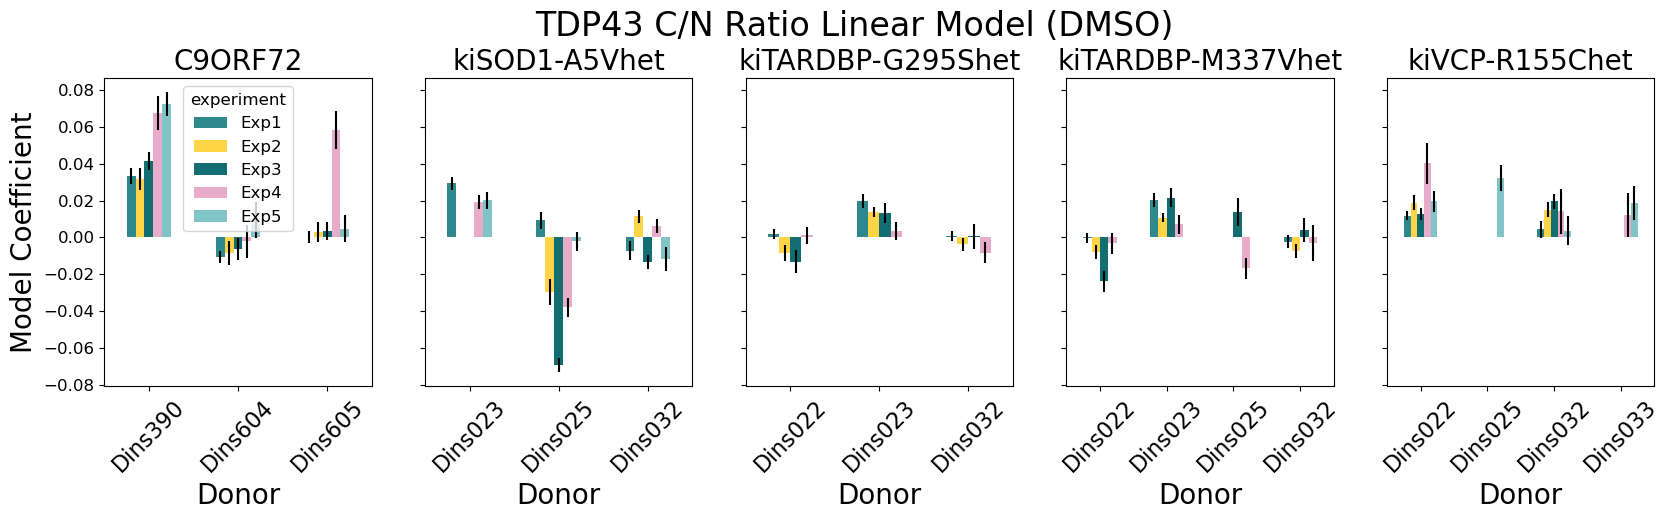

In [17]:
mutations_to_score = [
    'C9ORF72',
    'kiSOD1-A5Vhet',
    'kiTARDBP-G295Shet',
    'kiTARDBP-M337Vhet',
    'kiVCP-R155Chet',
]
subset = donor_stats[donor_stats.mutation.isin(mutations_to_score)]
plot_coeff(subset, f"linear-{norm_tdp43_ratio}", "0 DMSO")
plt.suptitle("TDP43 C/N Ratio Linear Model (DMSO)", y=1.05)

Text(0.5, 1.05, 'TDP43 C/N Ratio Linear Model (Bortezomib)')

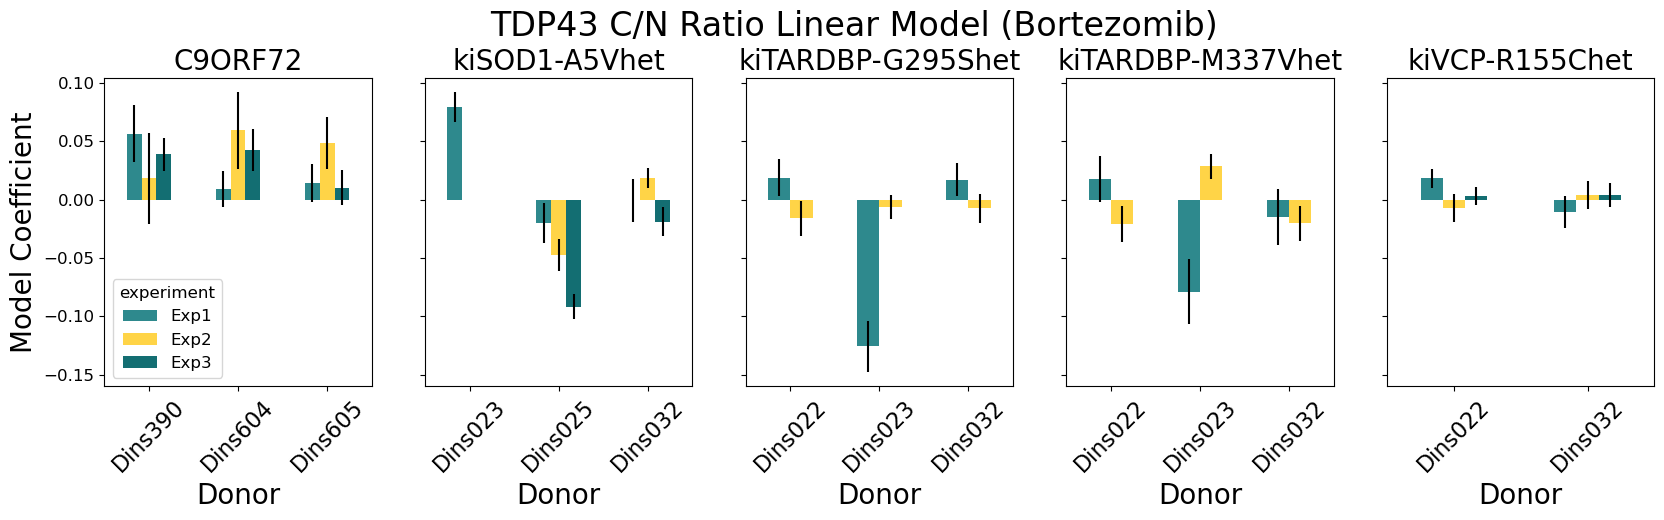

In [18]:
plot_coeff(subset, f"linear-{norm_tdp43_ratio}", "Bort")
plt.suptitle("TDP43 C/N Ratio Linear Model (Bortezomib)", y=1.05)

Text(0.5, 1.05, 'STMN2 Linear Model (DMSO)')

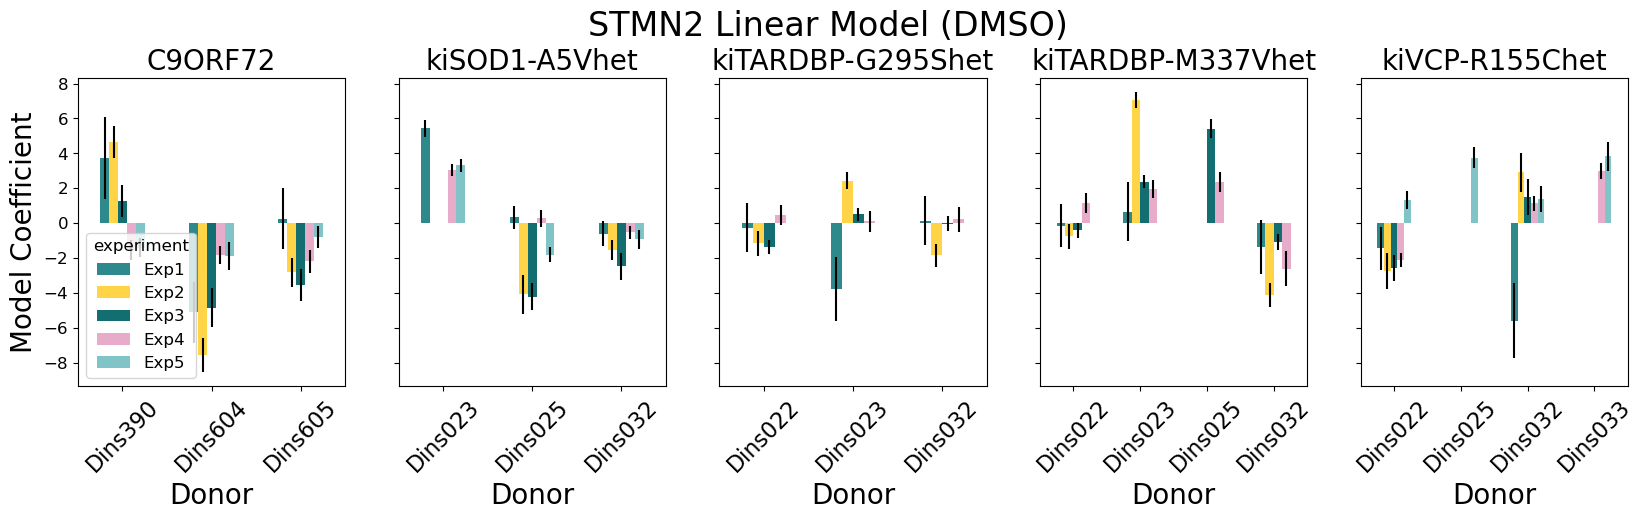

In [19]:
plot_coeff(subset, f"linear-{norm_stmn2}", "0 DMSO")
plt.suptitle("STMN2 Linear Model (DMSO)", y=1.05)

Text(0.5, 1.05, 'STMN2 (Neurites) Linear Model (DMSO)')

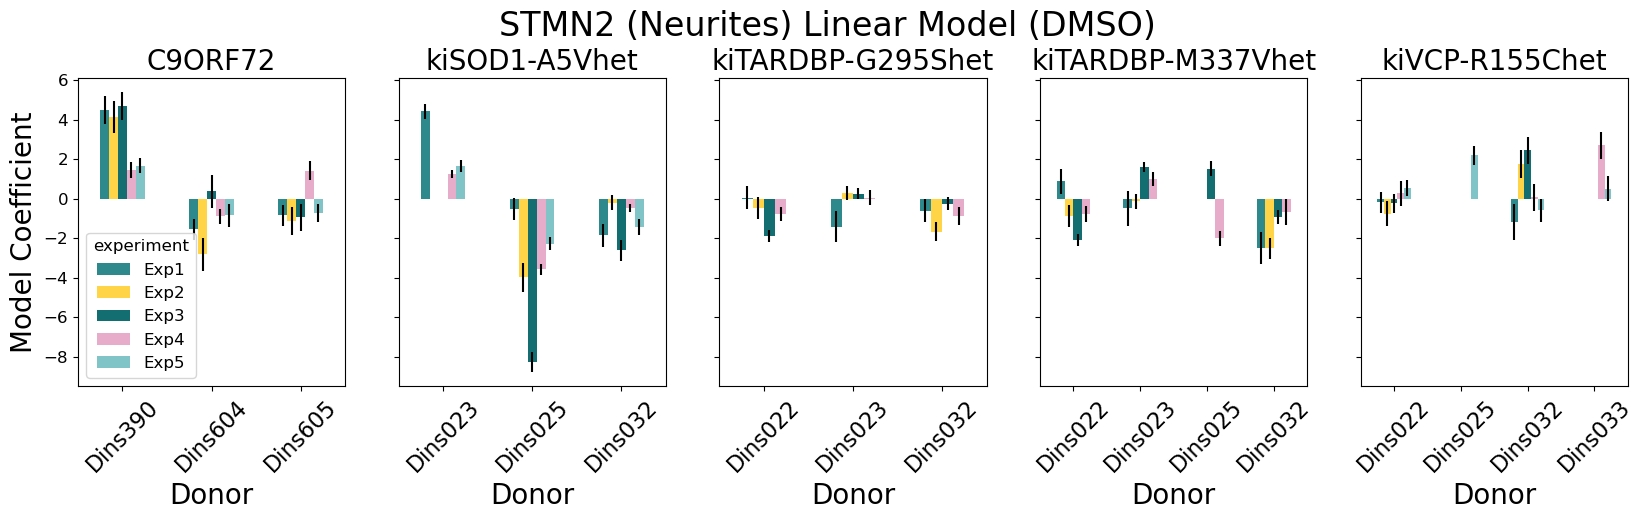

In [20]:
plot_coeff(subset, f"linear-{norm_stmn2_neurite}", "0 DMSO")
plt.suptitle("STMN2 (Neurites) Linear Model (DMSO)", y=1.05)

## Scatter plots
Of TDP-43 C/N and STMN2(soma/neurite) against density.  Controls Exp1 only.

Text(0.5, 46.0, 'Cell Count')

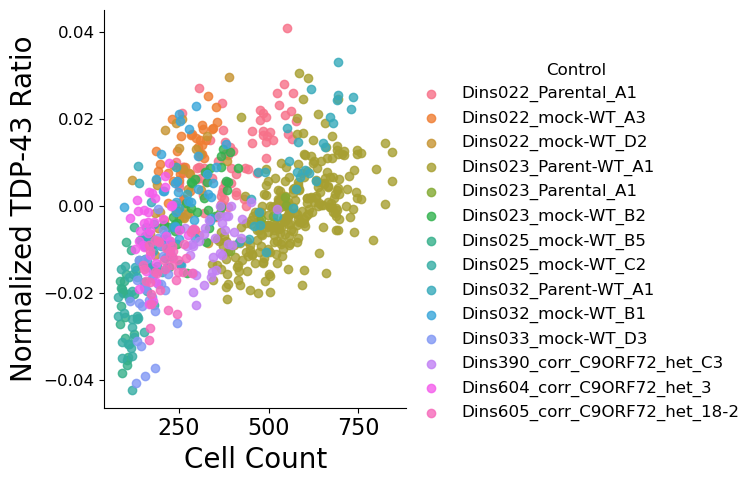

In [21]:
passing_wells_rel = duckdb.from_df(passing_wells)
sns.lmplot(
    data=passing_wells_rel.filter(
            f"""
            disease_category in ({wt_filter}) and
            compound_name in ('{dmso}') and
            experiment in ('Group1-4')
            """
        ).project(
            f"cell_line as Control, alive_in_well as Density, {norm_tdp43_ratio}"
        ).order("Control").df(),
    y=norm_tdp43_ratio,
    x="Density",
    hue="Control",
    fit_reg=False,
)
plt.ylabel("Normalized TDP-43 Ratio")
plt.xlabel("Cell Count")

Text(0.5, 46.0, 'Cell Count')

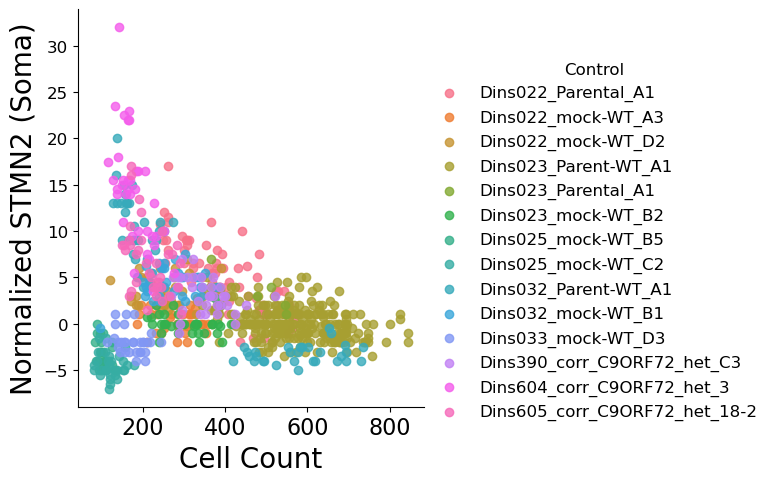

In [22]:
sns.lmplot(
    data=passing_wells_rel.filter(
            f"""
            disease_category in ({wt_filter}) and
            compound_name in ('{dmso}') and
            experiment in ('Group1-4')
            """
        ).project(
            f"cell_line as Control, alive_in_well as Density, {norm_stmn2}"
        ).order("Control").df(),
    y=norm_stmn2,
    x="Density",
    hue="Control",
    fit_reg=False,
)
plt.ylabel("Normalized STMN2 (Soma)")
plt.xlabel("Cell Count")

Text(0.5, 46.0, 'Cell Count')

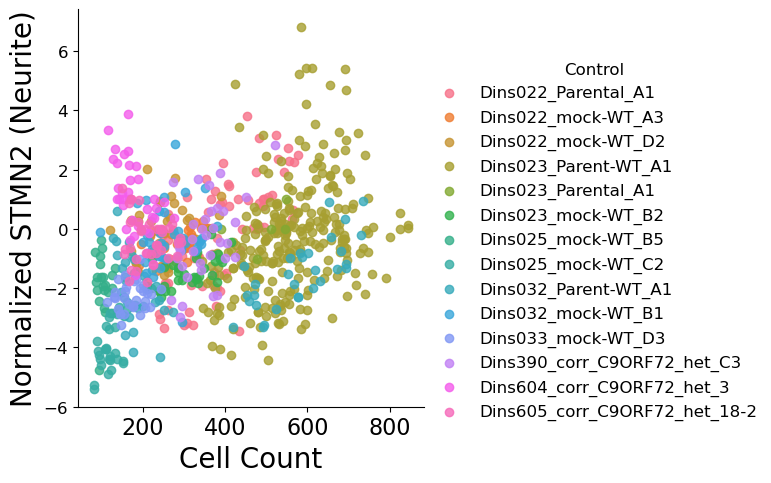

In [23]:
sns.lmplot(
    data=passing_wells_rel.filter(
            f"""
            disease_category in ({wt_filter}) and
            compound_name in ('{dmso}') and
            experiment in ('Group1-4')
            """
        ).project(
            f"cell_line as Control, alive_in_well as Density, {norm_stmn2_neurite}"
        ).order("Control").df(),
    y=norm_stmn2_neurite,
    x="Density",
    hue="Control",
    fit_reg=False,
)
plt.ylabel("Normalized STMN2 (Neurite)")
plt.xlabel("Cell Count")